## LeNet-5

***
`PREPARING THE MODEL`
***

In [30]:
import torch

has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cpu"
# device = "cpu"

print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

MPS (Apple Metal) is AVAILABLE
Target device is mps


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
# import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [43]:
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

In [32]:
# Hyperparameters
in_channels = 1
num_classes = 10
learning_rate = 0.001
batch_size = 8
num_epochs = 10

In [33]:
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_data = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

In [34]:
# GitHub: aladdinpersson

import torch
import torch.nn as nn


class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0)
        self.linear1 = nn.Linear(120, 84)
        self.linear2 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = x.reshape(x.shape[0], -1)
        h = x
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        
        return x, h


In [35]:
# Initialize model
model = LeNet5().to(device)

In [36]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

***
`TRAINING THE MODEL`
***

In [37]:
num = int(60000/batch_size/5)

for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0
    running_accuracy = 0.0

    print('Epoch:', epoch + 1, '\n')
    for batch, data in enumerate(train_loader):
        inputs = data[0].to(device=device)
        labels = data[1].to(device=device)

        optimizer.zero_grad()

        # forward
        outputs, _ = model(inputs)
        correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        running_accuracy += correct / batch_size
        
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # backward
        loss.backward()
        # gradient descent
        optimizer.step()
        
        if batch % num == num-1:
            avg_loss_across_batches = running_loss / num
            avg_acc_across_batches = (running_accuracy / num) * 100
            print('Batch {0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch+1, avg_loss_across_batches, avg_acc_across_batches))
            running_loss = 0.0
            running_accuracy = 0.0
    print('---------------------------------------------\n')

print("Done")

Epoch: 1 



Batch 1500, Loss: 0.416, Accuracy: 86.8%
Batch 3000, Loss: 0.146, Accuracy: 95.9%
Batch 4500, Loss: 0.105, Accuracy: 96.8%
Batch 6000, Loss: 0.088, Accuracy: 97.4%
Batch 7500, Loss: 0.079, Accuracy: 97.6%
---------------------------------------------

Epoch: 2 

Batch 1500, Loss: 0.063, Accuracy: 98.2%
Batch 3000, Loss: 0.065, Accuracy: 98.1%
Batch 4500, Loss: 0.059, Accuracy: 98.3%
Batch 6000, Loss: 0.062, Accuracy: 98.0%
Batch 7500, Loss: 0.056, Accuracy: 98.3%
---------------------------------------------

Epoch: 3 

Batch 1500, Loss: 0.046, Accuracy: 98.6%
Batch 3000, Loss: 0.043, Accuracy: 98.8%
Batch 4500, Loss: 0.046, Accuracy: 98.7%
Batch 6000, Loss: 0.042, Accuracy: 98.6%
Batch 7500, Loss: 0.037, Accuracy: 98.8%
---------------------------------------------

Epoch: 4 

Batch 1500, Loss: 0.028, Accuracy: 99.1%
Batch 3000, Loss: 0.030, Accuracy: 99.1%
Batch 4500, Loss: 0.033, Accuracy: 98.9%
Batch 6000, Loss: 0.035, Accuracy: 98.9%
Batch 7500, Loss: 0.033, Accuracy: 99.1%
------

***
`ACCURACY OF THE MODEL`
***

In [38]:
# Check accuracy of model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            # x = x.reshape(x.shape[0], -1)

            scores, _ = model(x)
            # loss = criterion(scores, y)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        # acc = float(num_correct) / float(num_samples)
        # print('Accuracy: ', acc)
        print(f'Got {num_correct}/{num_samples} with accuracy {float(num_correct) / float(num_samples)*100:.2f}')
        # print('Loss:', loss)
    
    model.train()

In [39]:
check_accuracy(test_loader, model)

Got 9906/10000 with accuracy 99.06


***
`ANALYZING THE MODEL`
***

In [40]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [42]:
images, labels, probs = get_predictions(model, test_loader, device)

In [44]:
pred_labels = torch.argmax(probs, 1)

***
`CONFUSION MATRIX`
***

In [45]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

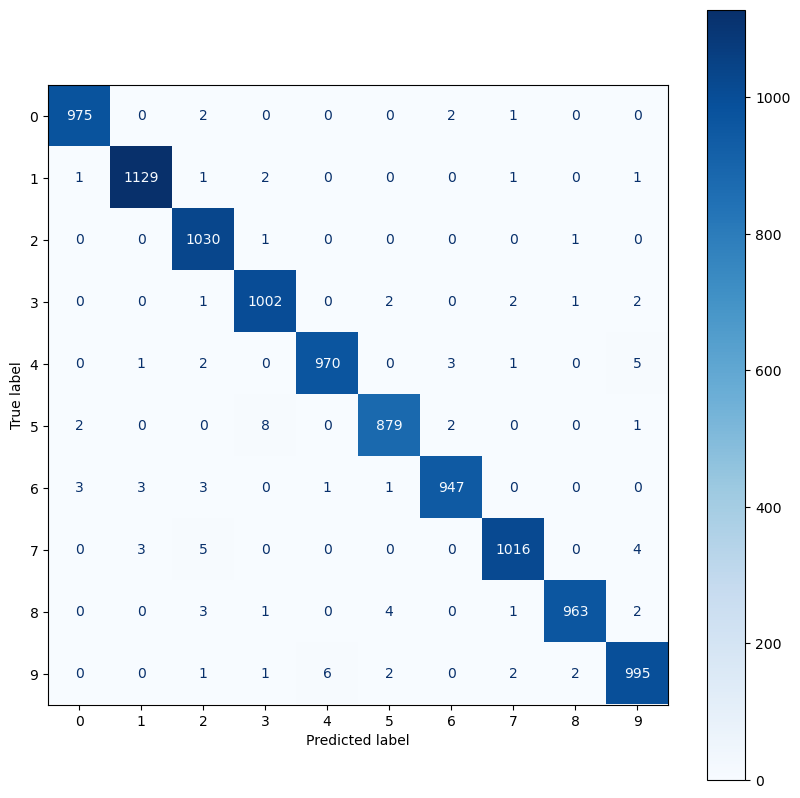

In [46]:
plot_confusion_matrix(labels, pred_labels)

***
`MOST INCORRECT GUESSES`
***

In [47]:
corrects = torch.eq(labels, pred_labels)

In [48]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

In [84]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(32, 32).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

The mistakes look pretty reasonable. All the digits shown here are a bit off.

As mentioned in the previous notebook, the model is always trained to be incredibly confident with its predictions, so it's not unreasonable for it to be incredibly confident when it's wrong.

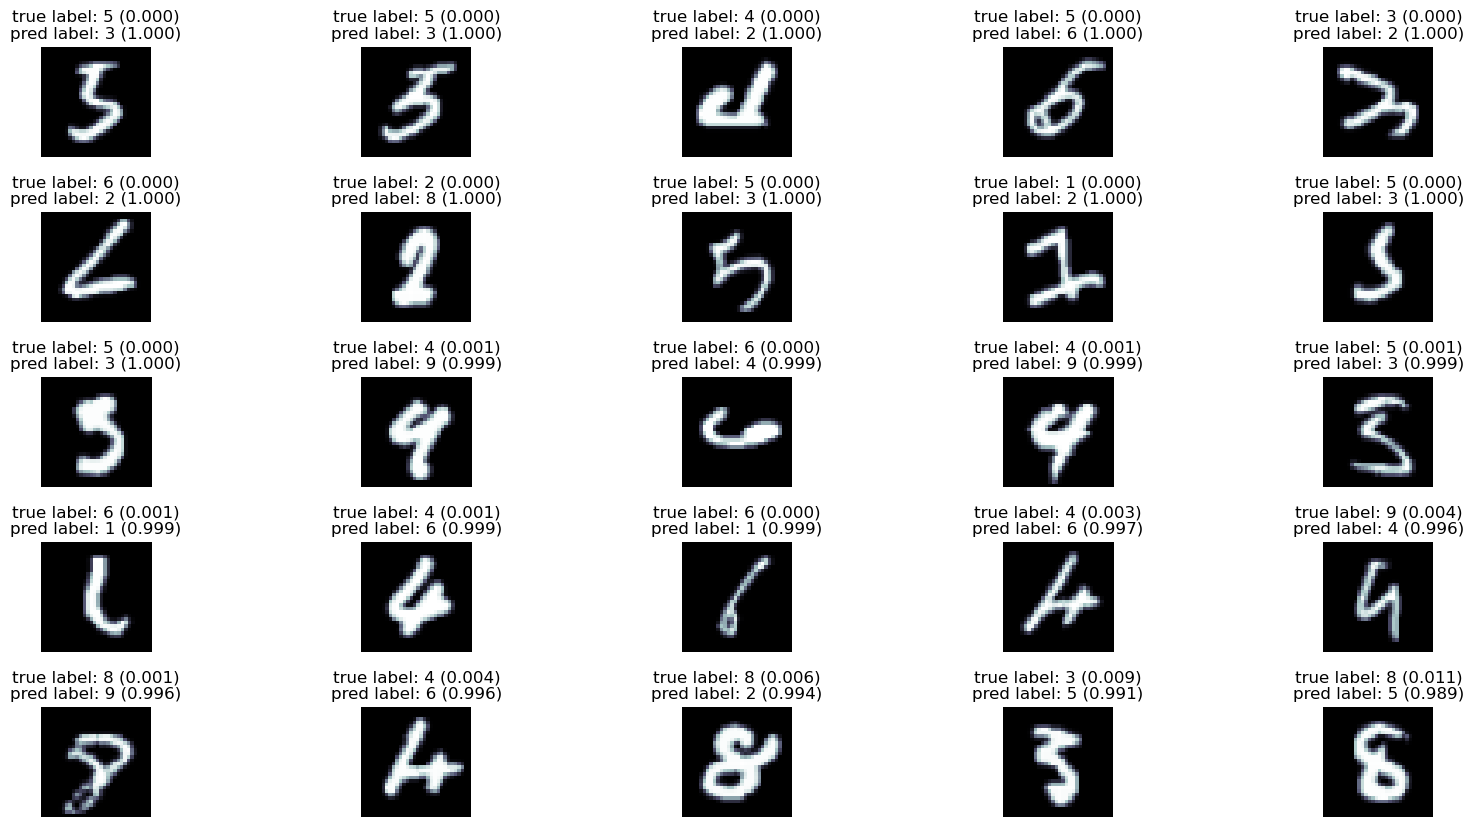

In [86]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

***
`LOWER DIMENSION VISUALIZATION`
***

In [51]:
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels

In [53]:
outputs, intermediates, labels = get_representations(model,
                                                     train_loader,
                                                     device)

  0%|          | 0/7500 [00:00<?, ?it/s]

***
`PCA PLOT`
***

In [54]:
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [55]:
def plot_representations(data, labels, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=labels)

In [56]:
output_pca_data = get_pca(outputs)

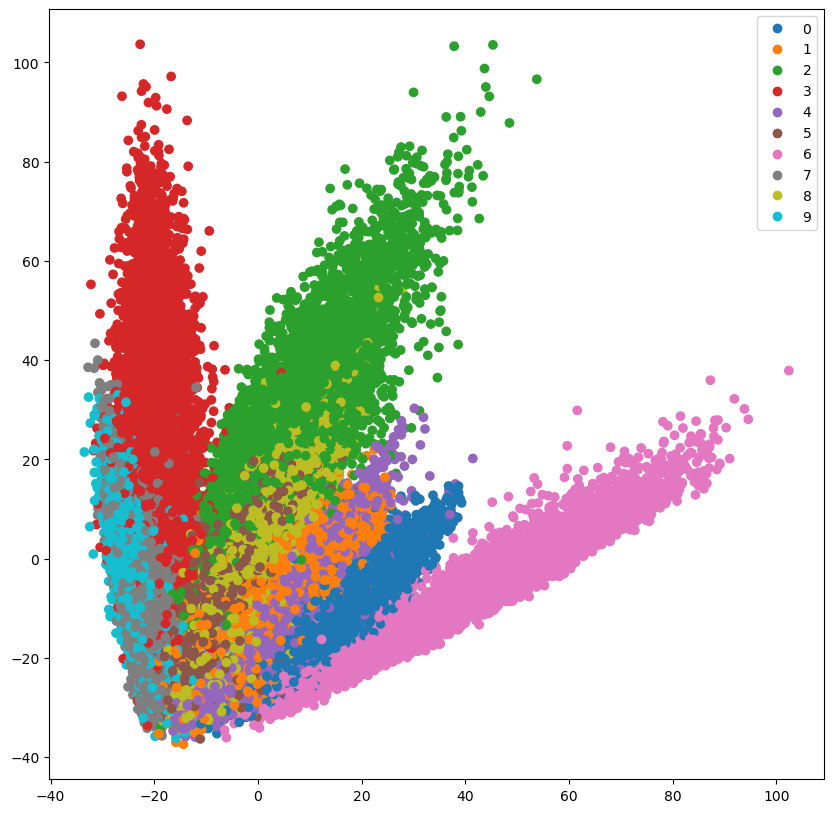

In [57]:
plot_representations(output_pca_data, labels)

Plotting the PCA representations of the intermediate values, just after the second set of convolutional and subsampling layers.

We can see that a lot of the classes are overlapped in one giant cluster. Intuitively, this makes sense, as the model has only extracted the features of the image so far and not yet passed them to the linear layers that will weight these features to make an actual prediction.

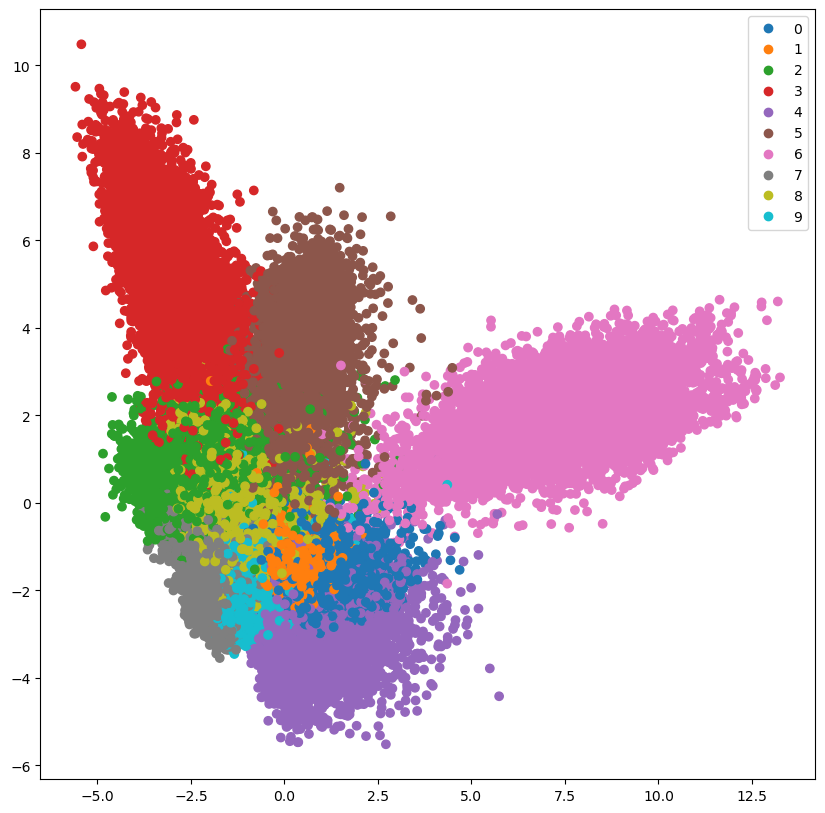

In [58]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels)

***
`t-SNE PLOT`
***

In [59]:
def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

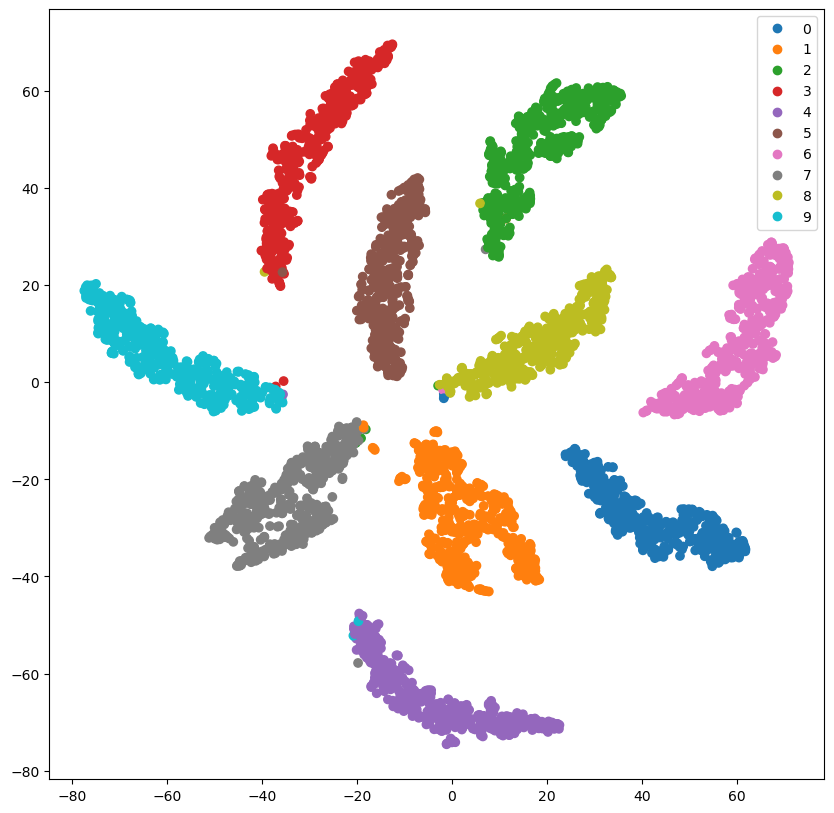

In [60]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images=N_IMAGES)
plot_representations(output_tsne_data, labels, n_images=N_IMAGES)

Again, the intermediate representations are more clustered, which adds more evidence to the theory that this is just a representation of the extracted features before the linear layers have had a chance to weight up evidence on the presence or absence of certain extracted features.

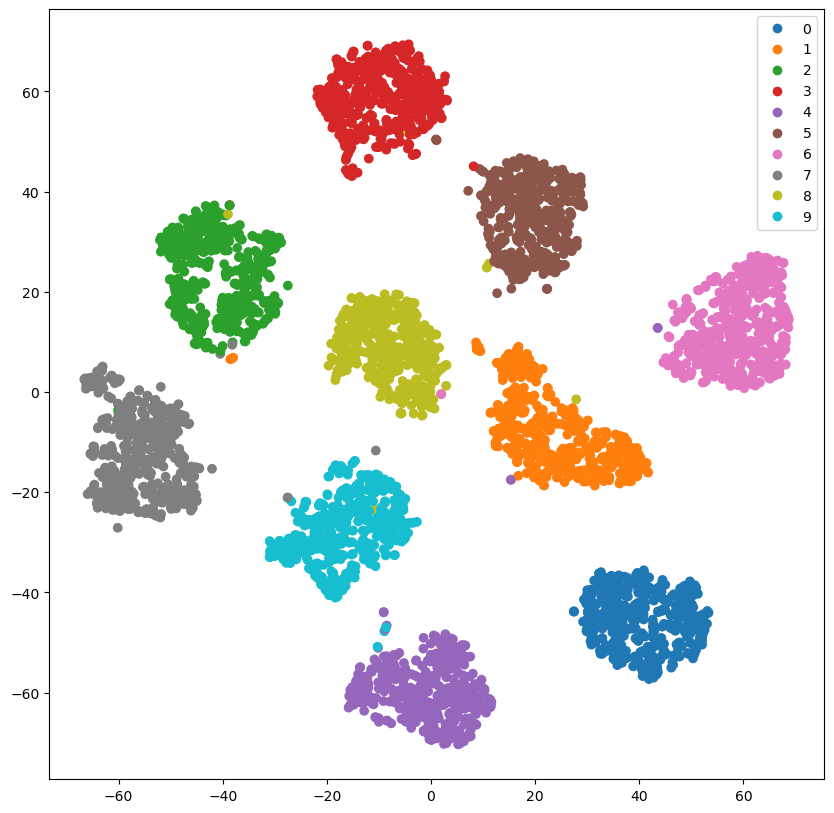

In [61]:
intermediate_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediate_tsne_data, labels, n_images=N_IMAGES)

***
`FILTERS`
***

In [87]:
def plot_filtered_images(images, filters):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filters = filters.cpu()

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize=(20, 10))

    for i in range(n_images):

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]
            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap='bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off')

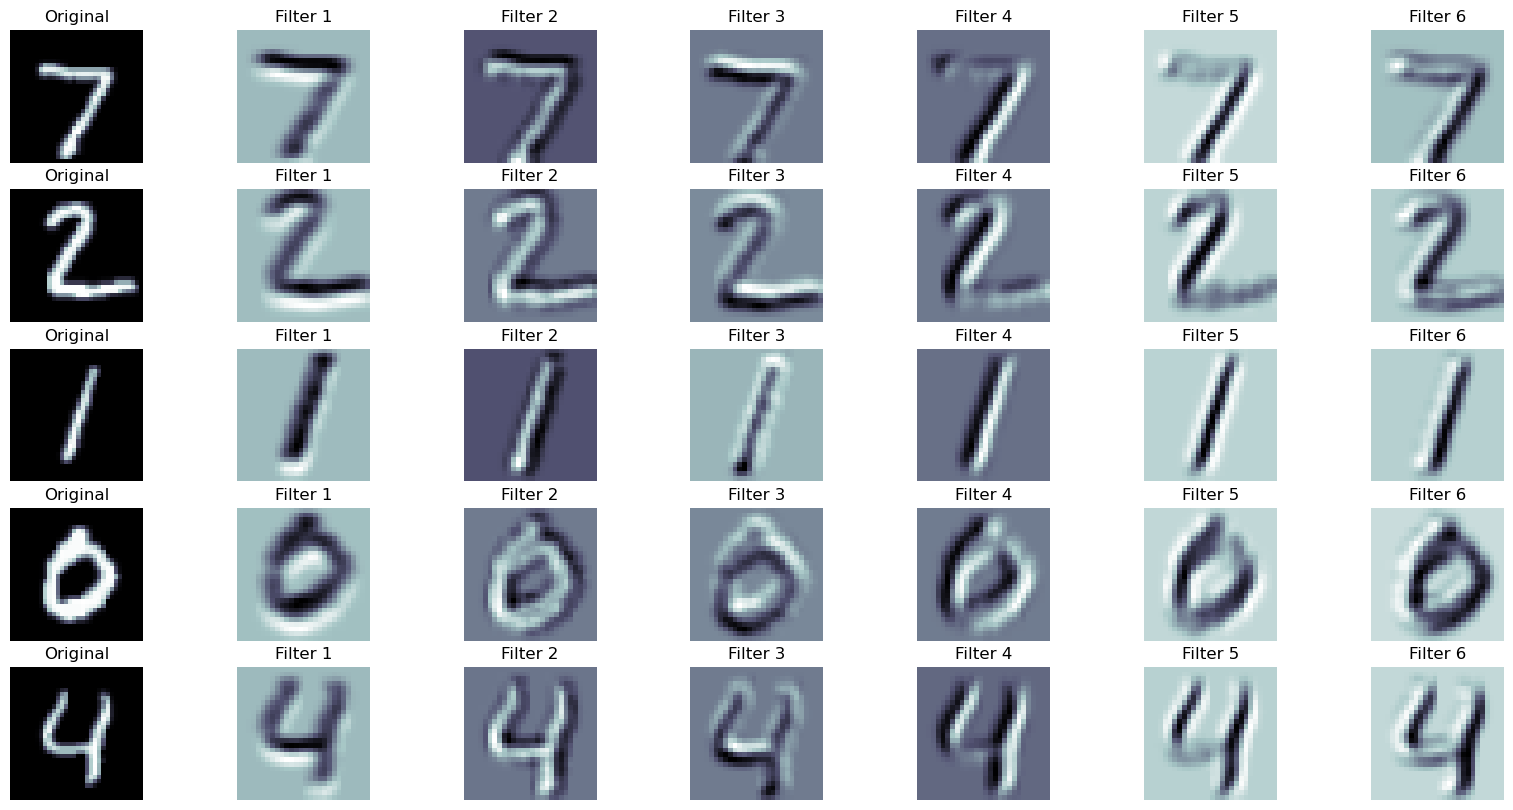

In [88]:
N_IMAGES = 5

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
filters = model.conv1.weight.data

plot_filtered_images(images, filters)

In [89]:
def plot_filters(filters):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    fig = plt.figure(figsize=(20, 10))

    for i in range(n_filters):

        ax = fig.add_subplot(1, n_filters, i+1)
        ax.imshow(filters[i].squeeze(0), cmap='bone')
        ax.axis('off')

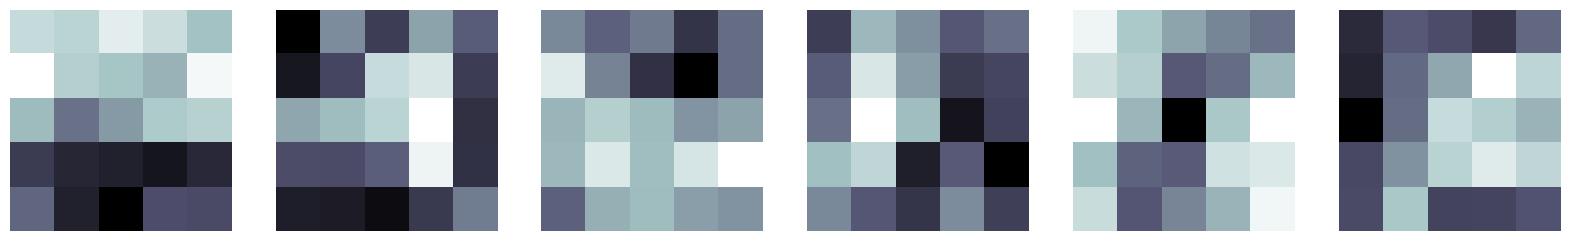

In [90]:
plot_filters(filters)

## References
Inspiration for this model came from the following:

Author: Aladdin Persson

Link: https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/CNN_architectures/lenet5_pytorch.py

Author: datahacker. rs

Link: https://www.youtube.com/watch?v=HPXnJmO8yQ4

Author: Ben Trevett

Link: https://github.com/bentrevett/pytorch-image-classification/blob/master/2_lenet.ipynb